# xFLS master catalogue
## Preparation of DataFusion-Spitzer data

The catalogue comes from `dmu0_DataFusion-Spitzer`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The aperture magnitude.
- The total magnitude.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
255270d (Fri Nov 24 10:35:51 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "spitzer_ra"
DEC_COL = "spitzer_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'internal_id': "spitzer_intid",
        'ra_spitzer': "spitzer_ra",
        'dec_spitzer': "spitzer_dec",
        'class_star_1':  "spitzer_stellarity", #Take IRAC1 stellarity
        'flux_auto_1': "f_irac_i1", 
        'fluxerr_auto_1': "ferr_irac_i1", 
        'flux_aper_2_1': "f_ap_irac_i1", #Is this 2 arcsec aperture
        'fluxerr_aper_2_1': "ferr_ap_irac_i1",
            'flux_auto_2': "f_irac_i2", 
        'fluxerr_auto_2': "ferr_irac_i2", 
        'flux_aper_2_2': "f_ap_irac_i2", 
        'fluxerr_aper_2_2': "ferr_ap_irac_i2",
            'flux_auto_3': "f_irac_i3", 
        'fluxerr_auto_3': "ferr_irac_i3", 
        'flux_aper_2_3': "f_ap_irac_i3", 
        'fluxerr_aper_2_3': "ferr_ap_irac_i3",
            'flux_auto_4': "f_irac_i4", 
        'fluxerr_auto_4': "ferr_irac_i4", 
        'flux_aper_2_4': "f_ap_irac_i4", 
        'fluxerr_aper_2_4': "ferr_ap_irac_i4",
    })


catalogue = Table.read("../../dmu0/dmu0_DataFusion-Spitzer/data/Datafusion-xFLS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
       

        mag, error = flux_to_mag(np.array(catalogue[col]) * 1.e-6, np.array(catalogue[errcol]) * 1.e-6)
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(error , name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [6]:
catalogue[:10].show_in_notebook()

idx,spitzer_intid,spitzer_ra,spitzer_dec,spitzer_stellarity,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i1,merr_irac_i1,flag_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,m_irac_i2,merr_irac_i2,flag_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,m_irac_i3,merr_irac_i3,flag_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,m_irac_i4,merr_irac_i4,flag_irac_i4,m_ap_irac_i4,merr_ap_irac_i4
,,deg,deg,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,,
0,1173051,261.161964,58.622196,0.15,31.865907462,18.6540333624,37.7387314696,15.9301441451,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.1416842734,0.63558081346,False,19.9580317552,0.458307250187,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
1,1175336,261.168937,58.644517,0.03,89.532383802,19.0419491376,62.9455123777,12.5770632326,nan,nan,nan,nan,77.185092234,38.9934282948,95.6504715446,45.2330454733,nan,nan,nan,nan,19.0200496306,0.230916822606,False,19.4025880673,0.216939578142,nan,nan,False,nan,nan,19.1811664313,0.548507174403,False,18.9482822115,0.513443941559,nan,nan,False,nan,nan
2,1174134,261.158816,58.637404,0.3,18.1127308998,9.1730241504,14.6779571111,6.84769880707,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.7550401628,0.549861005627,False,20.9833359641,0.506527881081,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
3,1174464,261.160986,58.640926,0.96,90.93929433,11.1773639628,93.4951143179,11.1235154918,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.0031210504,0.133448019556,False,18.9730277076,0.129174701607,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
4,1175556,261.169854,58.653266,1.0,30.4626624558,10.5978189048,38.828912969,10.3048837614,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.1905803543,0.37772258722,False,19.9271119188,0.28814572776,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
5,1176502,261.182591,58.66172,1.0,29.8997696298,9.8337996084,36.7935175386,10.3573174696,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.2108303945,0.357090117997,False,19.9855717268,0.305633038458,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
6,1176634,261.183707,58.663712,0.98,17.1319956654,9.5252256264,22.6398469239,8.98122280484,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.8154801104,0.603658938693,False,20.5128162847,0.430711338066,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
7,1176773,261.172812,58.662809,0.0,23.8856163516,10.8365347428,15.7763103962,5.9890432619,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.4546588689,0.492581724967,False,20.9049863941,0.412169952163,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan
8,1175478,261.170305,58.650375,0.16,32.8793176248,13.2391607448,33.3778813084,10.4644842065,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.1076930109,0.437181705085,False,20.0913530851,0.340395163556,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['ferr_ap_irac_i1', 'ferr_ap_irac_i2', 'ferr_ap_irac_i3', 'ferr_ap_irac_i4']
FLAG_NAME = 'spitzer_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 228354 sources.
The cleaned catalogue has 228354 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_xFLS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

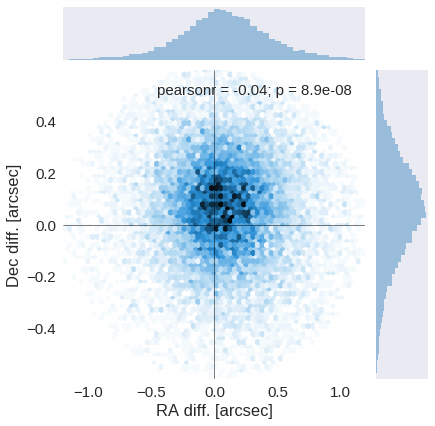

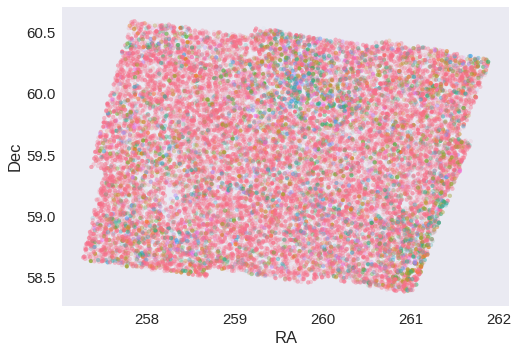

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], #catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.07282967051196465 arcsec
Dec correction: -0.06646679910460307 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

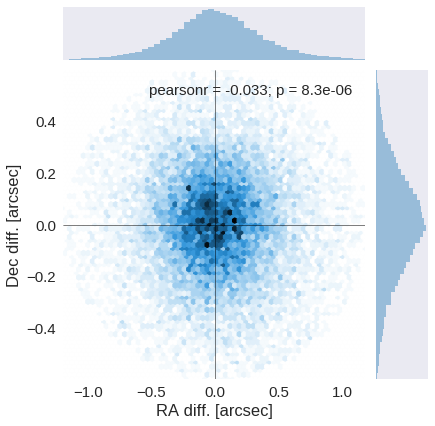

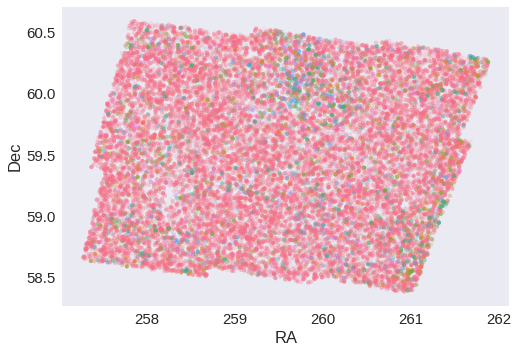

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "spitzer_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

21058 sources flagged.


# V - Saving to disk

In [15]:
catalogue.write("{}/Spitzer.fits".format(OUT_DIR), overwrite=True)